# Embryoscope Data Exploration

This notebook demonstrates how to explore and analyze embryoscope data stored in the DuckDB database.

In [1]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Connect to DuckDB Database

In [2]:
# Connect to the embryoscope database
db_path = "../../database/huntington_data_lake.duckdb"
conn = duckdb.connect(db_path)

print(f"Connected to database: {db_path}")

# List all schemas
print("\n=== Schemas ===")
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata;").fetchall()
for schema in schemas:
    print(f"  - {schema[0]}")

# List all tables
print("\n=== All Tables ===")
tables = conn.execute("SELECT table_name FROM information_schema.tables;").fetchall()
for table in tables:
    print(f"  - {table[0]}")

# List embryoscope schema tables specifically
schema = 'silver_embryoscope'
print(f"\n=== {schema} Schema Tables ===")
embryoscope_tables = conn.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema = '{schema}';").fetchall()
for table in embryoscope_tables:
    print(f"  - {schema}.{table[0]}")

conn.close()

Connected to database: ../../database/huntington_data_lake.duckdb

=== Schemas ===
  - gold
  - main
  - silver_embryoscope
  - information_schema
  - main
  - pg_catalog
  - main

=== All Tables ===
  - clinisys_embrioes
  - embryoscope_clinisys_combined
  - embryoscope_embrioes
  - data_embryo_data
  - data_patients
  - data_treatments
  - embryo_data
  - idascore
  - patients
  - treatments

=== silver_embryoscope Schema Tables ===
  - silver_embryoscope.data_embryo_data
  - silver_embryoscope.data_patients
  - silver_embryoscope.data_treatments
  - silver_embryoscope.embryo_data
  - silver_embryoscope.idascore
  - silver_embryoscope.patients
  - silver_embryoscope.treatments


## 2. Database Overview

In [3]:
# Get overview of data in each table
# Open connection
conn = duckdb.connect(db_path)
print("=== Database Overview ===\n")

data_tables = ['patients', 'treatments', 'embryo_data', 'idascore']

# system = 'embryoscope'
schema = 'silver_embryoscope'

for table in data_tables:
    try:
        # Get row count
        count = conn.execute(f"SELECT COUNT(*) FROM {schema}.{table}").fetchone()[0]
        
        # Get latest extraction timestamp
        latest = conn.execute(f"SELECT MAX(_extraction_timestamp) FROM {schema}.{table}").fetchone()[0]
        
        # Get unique locations
        locations = conn.execute(f"SELECT DISTINCT _location FROM {schema}.{table}").fetchall()
        location_list = [loc[0] for loc in locations]
        
        print(f"{table}:")
        print(f"  - Total rows: {count:,}")
        print(f"  - Latest extraction: {latest}")
        print(f"  - Locations: {location_list}")
        print()
        
    except Exception as e:
        print(f"{table}: Error - {e}\n")

# Close connection
conn.close()

=== Database Overview ===

patients:
  - Total rows: 11,875
  - Latest extraction: 2025-07-29 15:53:02.772282
  - Locations: ['Brasilia', 'Vila Mariana', 'Belo Horizonte', 'Ibirapuera']

treatments:
  - Total rows: 16,699
  - Latest extraction: 2025-07-29 15:53:02.772282
  - Locations: ['Ibirapuera', 'Belo Horizonte', 'Vila Mariana', 'Brasilia']

embryo_data:
  - Total rows: 126,356
  - Latest extraction: 2025-07-29 15:53:02.772282
  - Locations: ['Ibirapuera', 'Vila Mariana', 'Brasilia', 'Belo Horizonte']

idascore:
  - Total rows: 9,612
  - Latest extraction: 2025-07-29 15:40:25.722495
  - Locations: ['Vila Mariana']



## 3. Explore Patients Data

In [4]:
conn = duckdb.connect(db_path)
patients_query = f"""
SELECT * FROM  {schema}.patients 
ORDER BY _location, PatientIDx
"""
patients_df = conn.execute(patients_query).df()
conn.close()

print(f"Patients data shape: {patients_df.shape}")
patients_df.head()


Patients data shape: (11875, 10)


,PatientIDx,PatientID,FirstName,LastName,_extraction_timestamp,_location,_run_id,_row_hash,DateOfBirth,unit_huntington
0,NEXTGEN_44153.5200004514,68098,"MENEZES, RENATA GIACOMIN",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,42edf612d4a043534f5b2e218bec9aaf,NaT,Belo Horizonte
1,NEXTGEN_44539.5360013194,67202,"FONSECA, ANNA CAROLINA",FRANKLIN,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,9a4b1a4842035085ca4344489063fcb0,NaT,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,55510,"LEITE, AMANDA AYUPP GUIMARAES",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,b1c92d0709d0b633220c30d3585485f3,1985-04-01,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,63702,"SILVA, IRIS PATRICIA MESQUITA",DA,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,36e47420e80631bf09f37593f08e3c8b,1977-09-01,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,58834,"SOUZA, SORAIA",FELIX,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,46ed05b72bbe903763f8bcb7394ce091,1985-02-01,Belo Horizonte


In [5]:
patients_df

,PatientIDx,PatientID,FirstName,LastName,_extraction_timestamp,_location,_run_id,_row_hash,DateOfBirth,unit_huntington
0,NEXTGEN_44153.5200004514,68098,"MENEZES, RENATA GIACOMIN",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,42edf612d4a043534f5b2e218bec9aaf,NaT,Belo Horizonte
1,NEXTGEN_44539.5360013194,67202,"FONSECA, ANNA CAROLINA",FRANKLIN,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,9a4b1a4842035085ca4344489063fcb0,NaT,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,55510,"LEITE, AMANDA AYUPP GUIMARAES",PG,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,b1c92d0709d0b633220c30d3585485f3,1985-04-01,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,63702,"SILVA, IRIS PATRICIA MESQUITA",DA,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,36e47420e80631bf09f37593f08e3c8b,1977-09-01,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,58834,"SOUZA, SORAIA",FELIX,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,46ed05b72bbe903763f8bcb7394ce091,1985-02-01,Belo Horizonte
...,...,...,...,...,...,...,...,...,...,...
11870,PC1R85KM_45863.5068956366,519650,"ANCIOTO, KARINA",17/04/1986,2025-07-29 12:37:13.063610,Vila Mariana,c9d3d16a-1c00-4948-9c4d-69a0cf62c3c2,dcc559df874f6db9f5ba5091ac4cd372,1986-04-17,Vila Mariana
11871,PC1R85KM_45864.4592266782,892770,"GUIMARAES, LEYDIANE DUARTE",03/08/1982,2025-07-29 12:37:13.063610,Vila Mariana,c9d3d16a-1c00-4948-9c4d-69a0cf62c3c2,6b610254ed71e70fcd98e2c7cb2e4e84,1982-08-03,Vila Mariana
11872,PC1R85KM_45866.4470228472,863029,"TEIXEIRA, SUZELI",12/12/80,2025-07-29 12:37:13.063610,Vila Mariana,c9d3d16a-1c00-4948-9c4d-69a0cf62c3c2,c57fc753019f2066f1d7fd30923191aa,1980-12-12,Vila Mariana
11873,PC1R85KM_45867.4705672569,868251,"SILVA, JOICE A. C. DA",16/08/1981,2025-07-29 12:37:13.063610,Vila Mariana,c9d3d16a-1c00-4948-9c4d-69a0cf62c3c2,d54fe8ef479353075487335a1686a82f,1981-08-16,Vila Mariana


In [6]:
patients_df['DateOfBirth'].value_counts(dropna=False)

DateOfBirth
NaT           422
1979-03-01     39
1978-01-01     37
1981-11-01     36
1981-06-01     36
             ... 
1995-10-26      1
1979-08-18      1
1990-02-02      1
1982-04-04      1
1979-03-06      1
Name: count, Length: 4676, dtype: int64

Patients by location:
_location
Ibirapuera        5287
Vila Mariana      2664
Belo Horizonte    2266
Brasilia          1658
Name: count, dtype: int64


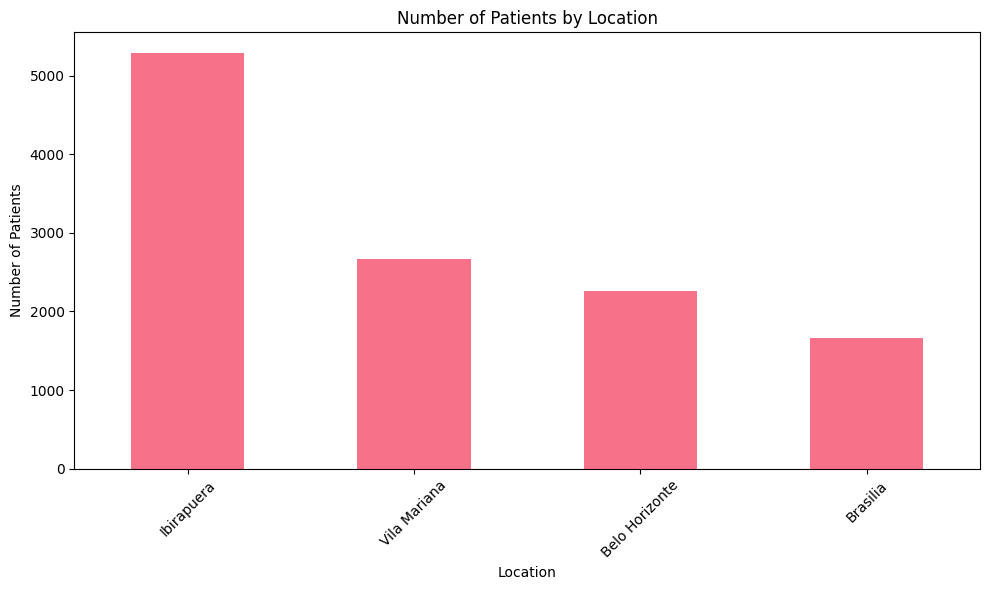

In [7]:
# Patients by location
patients_by_location = patients_df['_location'].value_counts()
print("Patients by location:")
print(patients_by_location)

# Plot patients by location
plt.figure(figsize=(10, 6))
patients_by_location.plot(kind='bar')
plt.title('Number of Patients by Location')
plt.xlabel('Location')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Explore Treatments Data

In [8]:
conn = duckdb.connect(db_path)

# Get latest treatments data
treatments_query = f"""
SELECT * FROM {schema}.treatments 
ORDER BY _location, PatientIDx
"""

treatments_df = conn.execute(treatments_query).df()
conn.close()

print(f"Treatments data shape: {treatments_df.shape}")
treatments_df.head()

Treatments data shape: (16699, 7)


,PatientIDx,TreatmentName,_extraction_timestamp,_location,_run_id,_row_hash,unit_huntington
0,NEXTGEN_44153.5200004514,18/11/2020,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,7490c267ccf8b6caf727d99e8299da54,Belo Horizonte
1,NEXTGEN_44539.5360013194,09/12/2021,2025-07-16 09:52:05.198485,Belo Horizonte,0c6e13e8-5703-46f6-a6b8-f48d7c4e1ebc,935dd1a9c308368240b7cb5e010ef1bb,Belo Horizonte
2,PC10T4JJ12641_43971.4735164352,20/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,54b9c4d153445f7c4c988a155fc38399,Belo Horizonte
3,PC10T4JJ12641_43972.4462907292,21/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,0e9cbb85e93b16e4be0d256569d104ed,Belo Horizonte
4,PC10T4JJ12641_43974.4114913542,23/05/2020,2025-07-16 09:49:20.941048,Belo Horizonte,e3be923f-dce1-4393-bf89-0574d3a56b74,10d0ee9ed812eca306d469fd3c9e1a01,Belo Horizonte


Treatments by location:
_location
Ibirapuera        8007
Vila Mariana      3539
Belo Horizonte    2940
Brasilia          2213
Name: count, dtype: int64

Treatments per patient:
count    11869.000000
mean         1.406942
std          0.849000
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         13.000000
dtype: float64


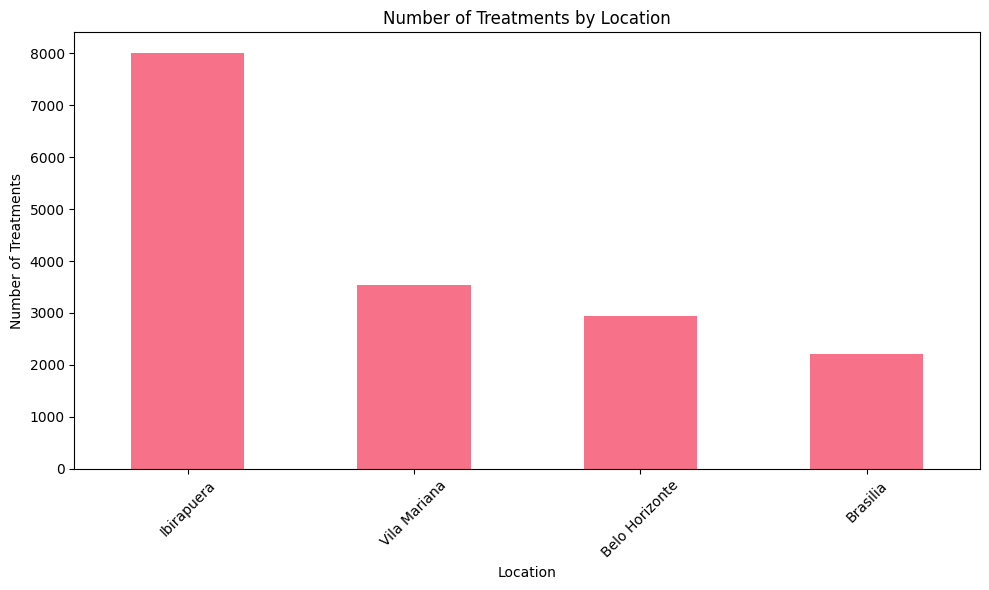

In [9]:
# Treatments analysis
print("Treatments by location:")
treatments_by_location = treatments_df['_location'].value_counts()
print(treatments_by_location)

print("\nTreatments per patient:")
treatments_per_patient = treatments_df.groupby(['_location', 'PatientIDx']).size()
print(treatments_per_patient.describe())

# Plot treatments by location
plt.figure(figsize=(10, 6))
treatments_by_location.plot(kind='bar')
plt.title('Number of Treatments by Location')
plt.xlabel('Location')
plt.ylabel('Number of Treatments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Explore Embryo Data

In [10]:
conn = duckdb.connect(db_path)

# Get latest embryo data
embryo_query = f"""
SELECT * FROM  {schema}.embryo_data 
ORDER BY _location, EmbryoID
"""

embryo_df = conn.execute(embryo_query).df()
conn.close()

print(f"Embryo data shape: {embryo_df.shape}")
embryo_df.head()



Embryo data shape: (126356, 245)


,EmbryoID,PatientIDx,TreatmentName,KIDDate,KIDScore,KIDUser,KIDVersion,Description,EmbryoDescriptionID,EmbryoFate,FertilizationMethod,FertilizationTime,InstrumentNumber,Name_BlastExpandLast,Name_Comment,Name_DynamicScore,Name_EVEN2,Name_EVEN4,Name_EVEN8,Name_Ellipse,Name_FRAG2,Name_FRAG2CAT,Name_FRAG4,Name_FRAG8,Name_ICM,Name_Line,Name_MN2Type,Name_MorphologicalGrade,Name_MorphologicalGradeD5,Name_Nuclei2,Name_Nuclei4,Name_Nuclei8,Name_PN,Name_Pulsing,Name_Strings,Name_TE,Name_Text,Name_ZScore,Name_t2,Name_t3,Name_t4,Name_t5,Name_t6,Name_t7,Name_t8,Name_t9,Name_tB,Name_tEB,Name_tHB,Name_tM,Name_tPB2,Name_tPNa,Name_tPNf,Name_tSB,Name_tSC,Position,Time_BlastExpandLast,Time_Comment,Time_DynamicScore,Time_EVEN2,Time_EVEN4,Time_EVEN8,Time_Ellipse,Time_FRAG2,Time_FRAG2CAT,Time_FRAG4,Time_FRAG8,Time_ICM,Time_Line,Time_MN2Type,Time_MorphologicalGrade,Time_MorphologicalGradeD5,Time_Nuclei2,Time_Nuclei4,Time_Nuclei8,Time_PN,Time_Pulsing,Time_Strings,Time_TE,Time_Text,Time_ZScore,Time_t2,Time_t3,Time_t4,Time_t5,Time_t6,Time_t7,Time_t8,Time_t9,Time_tB,Time_tEB,Time_tHB,Time_tM,Time_tPB2,Time_tPNa,Time_tPNf,Time_tSB,Time_tSC,Timestamp_BlastExpandLast,Timestamp_Comment,Timestamp_DynamicScore,Timestamp_EVEN2,Timestamp_EVEN4,Timestamp_EVEN8,Timestamp_Ellipse,Timestamp_FRAG2,Timestamp_FRAG2CAT,Timestamp_FRAG4,Timestamp_FRAG8,Timestamp_ICM,Timestamp_Line,Timestamp_MN2Type,Timestamp_MorphologicalGrade,Timestamp_MorphologicalGradeD5,Timestamp_Nuclei2,Timestamp_Nuclei4,Timestamp_Nuclei8,Timestamp_PN,Timestamp_Pulsing,Timestamp_Strings,Timestamp_TE,Timestamp_Text,Timestamp_ZScore,Timestamp_t2,Timestamp_t3,Timestamp_t4,Timestamp_t5,Timestamp_t6,Timestamp_t7,Timestamp_t8,Timestamp_t9,Timestamp_tB,Timestamp_tEB,Timestamp_tHB,Timestamp_tM,Timestamp_tPB2,Timestamp_tPNa,Timestamp_tPNf,Timestamp_tSB,Timestamp_tSC,Value_BlastExpandLast,Value_Comment,Value_DynamicScore,Value_EVEN2,Value_EVEN4,Value_EVEN8,Value_Ellipse,Value_FRAG2,Value_FRAG2CAT,Value_FRAG4,Value_FRAG8,Value_ICM,Value_Line,Value_MN2Type,Value_MorphologicalGrade,Value_MorphologicalGradeD5,Value_Nuclei2,Value_Nuclei4,Value_Nuclei8,Value_PN,Value_Pulsing,Value_Strings,Value_TE,Value_Text,Value_ZScore,Value_t2,Value_t3,Value_t4,Value_t5,Value_t6,Value_t7,Value_t8,Value_t9,Value_tB,Value_tEB,Value_tHB,Value_tM,Value_tPB2,Value_tPNa,Value_tPNf,Value_tSB,Value_tSC,WellNumber,_extraction_timestamp,_location,_row_hash,_run_id,embryo_number,unit_huntington,Name_Arrow,Name_MN4Type,Name_ReexpansionCount,Time_Arrow,Time_MN4Type,Time_ReexpansionCount,Timestamp_Arrow,Timestamp_MN4Type,Timestamp_ReexpansionCount,Value_Arrow,Value_MN4Type,Value_ReexpansionCount,Name_BlastomereSize,Name_Fragmentation,Name_IrregularDivision,Name_MultiNucleation,Name_Nuclei,Name_USRVAR_1_RC,Name_USRVAR_2_FD,Name_USRVAR_3_D1-3,Name_USRVAR_4_D2+,Name_USRVAR_5_PULSING,Name_tDead,Time_BlastomereSize,Time_Fragmentation,Time_IrregularDivision,Time_MultiNucleation,Time_Nuclei,Time_USRVAR_1_RC,Time_USRVAR_2_FD,Time_USRVAR_3_D1-3,Time_USRVAR_4_D2+,Time_USRVAR_5_PULSING,Time_tDead,Timestamp_BlastomereSize,Timestamp_Fragmentation,Timestamp_IrregularDivision,Timestamp_MultiNucleation,Timestamp_Nuclei,Timestamp_USRVAR_1_RC,Timestamp_USRVAR_2_FD,Timestamp_USRVAR_3_D1-3,Timestamp_USRVAR_4_D2+,Timestamp_USRVAR_5_PULSING,Timestamp_tDead,Value_BlastomereSize,Value_Fragmentation,Value_IrregularDivision,Value_MultiNucleation,Value_Nuclei,Value_USRVAR_1_RC,Value_USRVAR_2_FD,Value_USRVAR_3_D1-3,Value_USRVAR_4_D2+,Value_USRVAR_5_PULSING,Value_tDead
0,D2019.06.13_S00021_I3254_P-1,PC10T4JJ55173_43629.4403575000,13/06/2019,2019-06-14,NA,ADMIN,KIDScore D3 v1.1,None,AA1,Freeze,None,2019-06-13 12:00:00,3254,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,PN,None,None,None,None,None,t2,t3,t4,t5,None,None,t8,None,None,None,None,tM,tPB2,tPNa,tPNf,None,tSC,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,NaN,NaN,NaN,NaN,NaN,27.2,38.5,42.0,54.3,NaN,NaN,62.9,NaN,NaN,NaN,NaN,107.5,2.8

Embryos by location:
_location
Ibirapuera        56961
Vila Mariana      30170
Belo Horizonte    22693
Brasilia          16532
Name: count, dtype: int64

Embryo fates:
EmbryoFate
Avoid                   69471
Freeze                  38234
Unknown                  8530
FrozenEmbryoTransfer     6517
Transfer                 2993
Undecided                 611
Name: count, dtype: int64


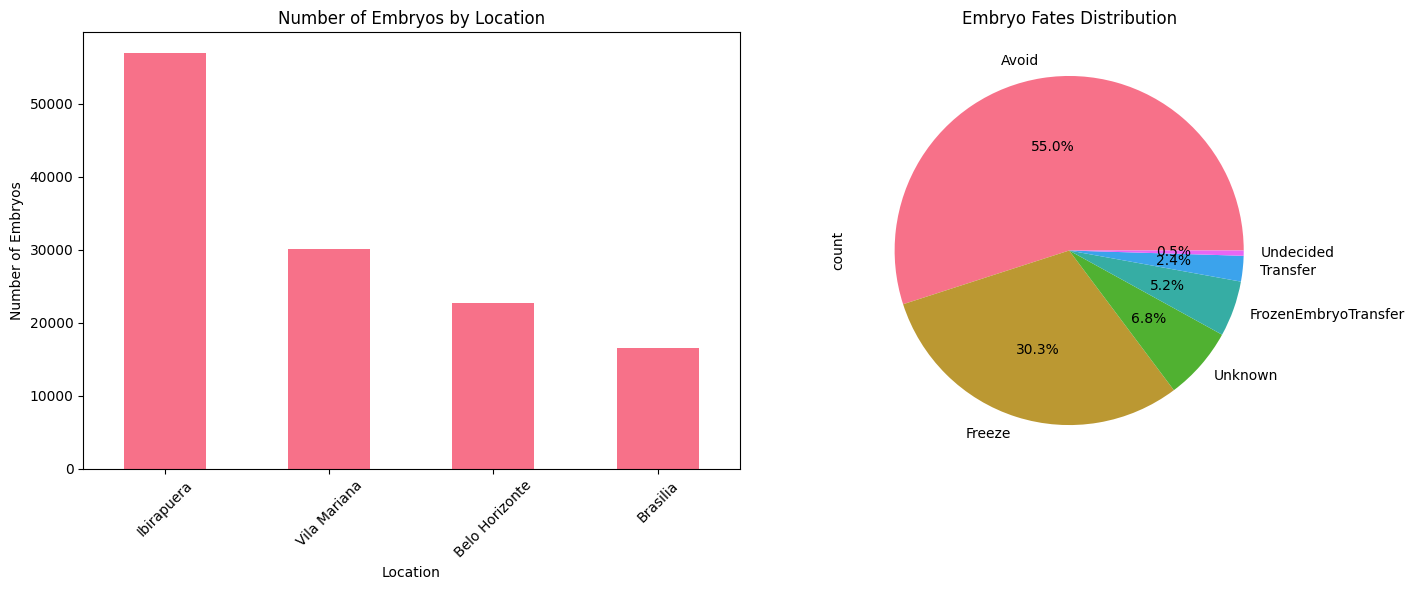

In [11]:
# Embryo analysis
print("Embryos by location:")
embryos_by_location = embryo_df['_location'].value_counts()
print(embryos_by_location)

print("\nEmbryo fates:")
embryo_fates = embryo_df['EmbryoFate'].value_counts()
print(embryo_fates)

# Plot embryos by location
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

embryos_by_location.plot(kind='bar', ax=ax1)
ax1.set_title('Number of Embryos by Location')
ax1.set_xlabel('Location')
ax1.set_ylabel('Number of Embryos')
ax1.tick_params(axis='x', rotation=45)

embryo_fates.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Embryo Fates Distribution')

plt.tight_layout()
plt.show()

## 6. Explore IDA Score Data

In [12]:
conn = duckdb.connect(db_path)

# Get latest IDA score data
idascore_query = f"""
SELECT * FROM  {schema}.idascore 
ORDER BY _location, EmbryoID
"""

idascore_df = conn.execute(idascore_query).df()
conn.close()

print(f"IDA Score data shape: {idascore_df.shape}")
idascore_df.head()


IDA Score data shape: (9612, 10)


,EmbryoID,IDAScore,IDATime,IDAVersion,IDATimestamp,_extraction_timestamp,_location,_run_id,_row_hash,unit_huntington
0,D2019.06.19_S00028_I3253_P-1,1.03,115,2.0.4,2024.04.30 07:55:37,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,212cbf29a4c410bb654943824050d577,Vila Mariana
1,D2019.06.19_S00028_I3253_P-2,1.05,115,2.0.4,2024.04.30 07:55:35,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,87d5649e334849ef00382e85bf0d479c,Vila Mariana
2,D2019.06.19_S00028_I3253_P-3,1.06,115,2.0.4,2024.04.30 07:55:33,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,04ba8020f5111c86dca22000e6e8736e,Vila Mariana
3,D2019.06.19_S00028_I3253_P-4,1.01,115,2.0.4,2024.04.30 07:56:06,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,3951e556b9a198c43620aba73ee02db4,Vila Mariana
4,D2019.07.03_S00054_I3253_P-11,8.15,120,2.0.4,2024.05.28 15:20:09,2025-07-15 19:21:41.460065,Vila Mariana,5a1a0509-7c67-43d2-a882-27ef8fcbf469,64fd55ee987af775ee05eb47cf1c8bf7,Vila Mariana


IDA Scores by location:
_location
Vila Mariana    9612
Name: count, dtype: int64

Score statistics:
count     9612
unique     848
top       1.01
freq       679
Name: IDAScore, dtype: object

Viability distribution:
IDAScore
1.01    679
1.05    415
1.04    399
1.0     351
1.06    336
       ... 
4.19      1
9.41      1
9.61      1
9.66      1
7.81      1
Name: count, Length: 848, dtype: int64


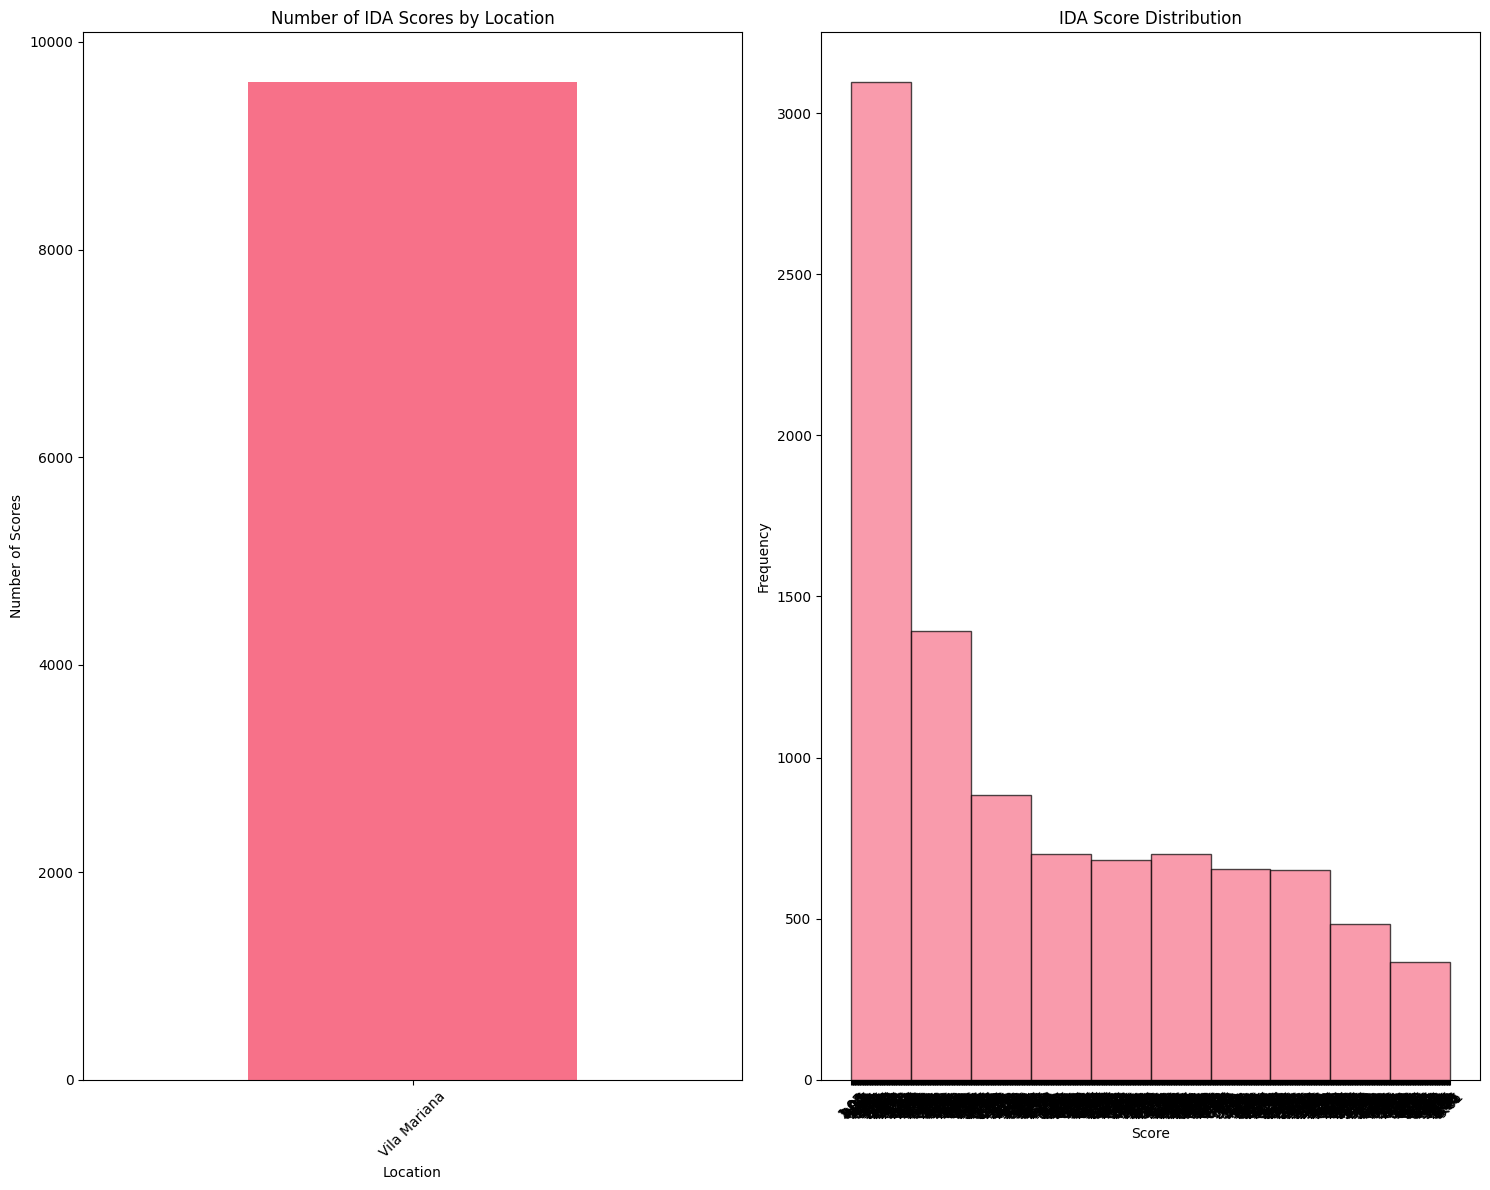

In [13]:
# IDA Score analysis
print("IDA Scores by location:")
idascore_by_location = idascore_df['_location'].value_counts()
print(idascore_by_location)

print("\nScore statistics:")
print(idascore_df['IDAScore'].describe())

print("\nViability distribution:")
viability_dist = idascore_df['IDAScore'].value_counts()
print(viability_dist)

# Plot IDA scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 12))

# Scores by location
idascore_by_location.plot(kind='bar', ax=ax1)
ax1.set_title('Number of IDA Scores by Location')
ax1.set_xlabel('Location')
ax1.set_ylabel('Number of Scores')
ax1.tick_params(axis='x', rotation=45)

# Score distribution
ax2.hist(idascore_df['IDAScore'].dropna(), bins=10, alpha=0.7, edgecolor='black')
ax2.set_title('IDA Score Distribution')
ax2.set_xlabel('Score')
ax2.set_ylabel('Frequency')
for ax in [ax1, ax2]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

## 7. Combined Analysis

In [14]:
conn = duckdb.connect(db_path)

# Create a comprehensive view combining all data
comprehensive_query = f"""
WITH latest_patients AS (
SELECT * FROM  {schema}.patients 
--    WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM  embryoscope.data_patients)
),
latest_treatments AS (
    SELECT * FROM {schema}.treatments 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_treatments)
),
latest_embryos AS (
    SELECT * FROM {schema}.embryo_data 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_embryo_data)
),
-- Table data_idascore does not exist, so we cannot include latest_scores.
-- If/when the table is created, restore this CTE:
latest_scores AS (
   SELECT * FROM {schema}.idascore 
--     WHERE _extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM embryoscope.data_idascore)
)
SELECT 
    e.*,
    p.FirstName as PatientName,
    p.DateOfBirth,
    s.IDAScore
FROM latest_embryos e
LEFT JOIN latest_patients p ON e.PatientIDx = p.PatientIDx AND e._location = p._location
LEFT JOIN latest_scores s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
WHERE p.PatientID = '161746'
ORDER BY e._location, e.PatientIDx, e.EmbryoID
"""

comprehensive_df = conn.execute(comprehensive_query).df()
conn.close()

print(f"Comprehensive data shape: {comprehensive_df.shape}")
comprehensive_df.head()

Comprehensive data shape: (13, 248)


,EmbryoID,PatientIDx,TreatmentName,KIDDate,KIDScore,KIDUser,KIDVersion,Description,EmbryoDescriptionID,EmbryoFate,FertilizationMethod,FertilizationTime,InstrumentNumber,Name_BlastExpandLast,Name_Comment,Name_DynamicScore,Name_EVEN2,Name_EVEN4,Name_EVEN8,Name_Ellipse,Name_FRAG2,Name_FRAG2CAT,Name_FRAG4,Name_FRAG8,Name_ICM,Name_Line,Name_MN2Type,Name_MorphologicalGrade,Name_MorphologicalGradeD5,Name_Nuclei2,Name_Nuclei4,Name_Nuclei8,Name_PN,Name_Pulsing,Name_Strings,Name_TE,Name_Text,Name_ZScore,Name_t2,Name_t3,Name_t4,Name_t5,Name_t6,Name_t7,Name_t8,Name_t9,Name_tB,Name_tEB,Name_tHB,Name_tM,Name_tPB2,Name_tPNa,Name_tPNf,Name_tSB,Name_tSC,Position,Time_BlastExpandLast,Time_Comment,Time_DynamicScore,Time_EVEN2,Time_EVEN4,Time_EVEN8,Time_Ellipse,Time_FRAG2,Time_FRAG2CAT,Time_FRAG4,Time_FRAG8,Time_ICM,Time_Line,Time_MN2Type,Time_MorphologicalGrade,Time_MorphologicalGradeD5,Time_Nuclei2,Time_Nuclei4,Time_Nuclei8,Time_PN,Time_Pulsing,Time_Strings,Time_TE,Time_Text,Time_ZScore,Time_t2,Time_t3,Time_t4,Time_t5,Time_t6,Time_t7,Time_t8,Time_t9,Time_tB,Time_tEB,Time_tHB,Time_tM,Time_tPB2,Time_tPNa,Time_tPNf,Time_tSB,Time_tSC,Timestamp_BlastExpandLast,Timestamp_Comment,Timestamp_DynamicScore,Timestamp_EVEN2,Timestamp_EVEN4,Timestamp_EVEN8,Timestamp_Ellipse,Timestamp_FRAG2,Timestamp_FRAG2CAT,Timestamp_FRAG4,Timestamp_FRAG8,Timestamp_ICM,Timestamp_Line,Timestamp_MN2Type,Timestamp_MorphologicalGrade,Timestamp_MorphologicalGradeD5,Timestamp_Nuclei2,Timestamp_Nuclei4,Timestamp_Nuclei8,Timestamp_PN,Timestamp_Pulsing,Timestamp_Strings,Timestamp_TE,Timestamp_Text,Timestamp_ZScore,Timestamp_t2,Timestamp_t3,Timestamp_t4,Timestamp_t5,Timestamp_t6,Timestamp_t7,Timestamp_t8,Timestamp_t9,Timestamp_tB,Timestamp_tEB,Timestamp_tHB,Timestamp_tM,Timestamp_tPB2,Timestamp_tPNa,Timestamp_tPNf,Timestamp_tSB,Timestamp_tSC,Value_BlastExpandLast,Value_Comment,Value_DynamicScore,Value_EVEN2,Value_EVEN4,Value_EVEN8,Value_Ellipse,Value_FRAG2,Value_FRAG2CAT,Value_FRAG4,Value_FRAG8,Value_ICM,Value_Line,Value_MN2Type,Value_MorphologicalGrade,Value_MorphologicalGradeD5,Value_Nuclei2,Value_Nuclei4,Value_Nuclei8,Value_PN,Value_Pulsing,Value_Strings,Value_TE,Value_Text,Value_ZScore,Value_t2,Value_t3,Value_t4,Value_t5,Value_t6,Value_t7,Value_t8,Value_t9,Value_tB,Value_tEB,Value_tHB,Value_tM,Value_tPB2,Value_tPNa,Value_tPNf,Value_tSB,Value_tSC,WellNumber,_extraction_timestamp,_location,_row_hash,_run_id,embryo_number,unit_huntington,Name_Arrow,Name_MN4Type,Name_ReexpansionCount,Time_Arrow,Time_MN4Type,Time_ReexpansionCount,Timestamp_Arrow,Timestamp_MN4Type,Timestamp_ReexpansionCount,Value_Arrow,Value_MN4Type,Value_ReexpansionCount,Name_BlastomereSize,Name_Fragmentation,Name_IrregularDivision,Name_MultiNucleation,Name_Nuclei,Name_USRVAR_1_RC,Name_USRVAR_2_FD,Name_USRVAR_3_D1-3,Name_USRVAR_4_D2+,Name_USRVAR_5_PULSING,Name_tDead,Time_BlastomereSize,Time_Fragmentation,Time_IrregularDivision,Time_MultiNucleation,Time_Nuclei,Time_USRVAR_1_RC,Time_USRVAR_2_FD,Time_USRVAR_3_D1-3,Time_USRVAR_4_D2+,Time_USRVAR_5_PULSING,Time_tDead,Timestamp_BlastomereSize,Timestamp_Fragmentation,Timestamp_IrregularDivision,Timestamp_MultiNucleation,Timestamp_Nuclei,Timestamp_USRVAR_1_RC,Timestamp_USRVAR_2_FD,Timestamp_USRVAR_3_D1-3,Timestamp_USRVAR_4_D2+,Timestamp_USRVAR_5_PULSING,Timestamp_tDead,Value_BlastomereSize,Value_Fragmentation,Value_IrregularDivision,Value_MultiNucleation,Value_Nuclei,Value_USRVAR_1_RC,Value_USRVAR_2_FD,Value_USRVAR_3_D1-3,Value_USRVAR_4_D2+,Value_USRVAR_5_PULSING,Value_tDead,PatientName,DateOfBirth,IDAScore
0,D2025.07.12_S04193_I3027_P-1,PC1P7BHG_45850.4034504514,2025 - 1433,2025-07-18,NA,ADMIN,KIDScoreD5 v3.3,None,AA1,Avoid,None,2025-07-12 11:35:00,3027,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [15]:
comprehensive_df

,EmbryoID,PatientIDx,TreatmentName,KIDDate,KIDScore,KIDUser,KIDVersion,Description,EmbryoDescriptionID,EmbryoFate,FertilizationMethod,FertilizationTime,InstrumentNumber,Name_BlastExpandLast,Name_Comment,Name_DynamicScore,Name_EVEN2,Name_EVEN4,Name_EVEN8,Name_Ellipse,Name_FRAG2,Name_FRAG2CAT,Name_FRAG4,Name_FRAG8,Name_ICM,Name_Line,Name_MN2Type,Name_MorphologicalGrade,Name_MorphologicalGradeD5,Name_Nuclei2,Name_Nuclei4,Name_Nuclei8,Name_PN,Name_Pulsing,Name_Strings,Name_TE,Name_Text,Name_ZScore,Name_t2,Name_t3,Name_t4,Name_t5,Name_t6,Name_t7,Name_t8,Name_t9,Name_tB,Name_tEB,Name_tHB,Name_tM,Name_tPB2,Name_tPNa,Name_tPNf,Name_tSB,Name_tSC,Position,Time_BlastExpandLast,Time_Comment,Time_DynamicScore,Time_EVEN2,Time_EVEN4,Time_EVEN8,Time_Ellipse,Time_FRAG2,Time_FRAG2CAT,Time_FRAG4,Time_FRAG8,Time_ICM,Time_Line,Time_MN2Type,Time_MorphologicalGrade,Time_MorphologicalGradeD5,Time_Nuclei2,Time_Nuclei4,Time_Nuclei8,Time_PN,Time_Pulsing,Time_Strings,Time_TE,Time_Text,Time_ZScore,Time_t2,Time_t3,Time_t4,Time_t5,Time_t6,Time_t7,Time_t8,Time_t9,Time_tB,Time_tEB,Time_tHB,Time_tM,Time_tPB2,Time_tPNa,Time_tPNf,Time_tSB,Time_tSC,Timestamp_BlastExpandLast,Timestamp_Comment,Timestamp_DynamicScore,Timestamp_EVEN2,Timestamp_EVEN4,Timestamp_EVEN8,Timestamp_Ellipse,Timestamp_FRAG2,Timestamp_FRAG2CAT,Timestamp_FRAG4,Timestamp_FRAG8,Timestamp_ICM,Timestamp_Line,Timestamp_MN2Type,Timestamp_MorphologicalGrade,Timestamp_MorphologicalGradeD5,Timestamp_Nuclei2,Timestamp_Nuclei4,Timestamp_Nuclei8,Timestamp_PN,Timestamp_Pulsing,Timestamp_Strings,Timestamp_TE,Timestamp_Text,Timestamp_ZScore,Timestamp_t2,Timestamp_t3,Timestamp_t4,Timestamp_t5,Timestamp_t6,Timestamp_t7,Timestamp_t8,Timestamp_t9,Timestamp_tB,Timestamp_tEB,Timestamp_tHB,Timestamp_tM,Timestamp_tPB2,Timestamp_tPNa,Timestamp_tPNf,Timestamp_tSB,Timestamp_tSC,Value_BlastExpandLast,Value_Comment,Value_DynamicScore,Value_EVEN2,Value_EVEN4,Value_EVEN8,Value_Ellipse,Value_FRAG2,Value_FRAG2CAT,Value_FRAG4,Value_FRAG8,Value_ICM,Value_Line,Value_MN2Type,Value_MorphologicalGrade,Value_MorphologicalGradeD5,Value_Nuclei2,Value_Nuclei4,Value_Nuclei8,Value_PN,Value_Pulsing,Value_Strings,Value_TE,Value_Text,Value_ZScore,Value_t2,Value_t3,Value_t4,Value_t5,Value_t6,Value_t7,Value_t8,Value_t9,Value_tB,Value_tEB,Value_tHB,Value_tM,Value_tPB2,Value_tPNa,Value_tPNf,Value_tSB,Value_tSC,WellNumber,_extraction_timestamp,_location,_row_hash,_run_id,embryo_number,unit_huntington,Name_Arrow,Name_MN4Type,Name_ReexpansionCount,Time_Arrow,Time_MN4Type,Time_ReexpansionCount,Timestamp_Arrow,Timestamp_MN4Type,Timestamp_ReexpansionCount,Value_Arrow,Value_MN4Type,Value_ReexpansionCount,Name_BlastomereSize,Name_Fragmentation,Name_IrregularDivision,Name_MultiNucleation,Name_Nuclei,Name_USRVAR_1_RC,Name_USRVAR_2_FD,Name_USRVAR_3_D1-3,Name_USRVAR_4_D2+,Name_USRVAR_5_PULSING,Name_tDead,Time_BlastomereSize,Time_Fragmentation,Time_IrregularDivision,Time_MultiNucleation,Time_Nuclei,Time_USRVAR_1_RC,Time_USRVAR_2_FD,Time_USRVAR_3_D1-3,Time_USRVAR_4_D2+,Time_USRVAR_5_PULSING,Time_tDead,Timestamp_BlastomereSize,Timestamp_Fragmentation,Timestamp_IrregularDivision,Timestamp_MultiNucleation,Timestamp_Nuclei,Timestamp_USRVAR_1_RC,Timestamp_USRVAR_2_FD,Timestamp_USRVAR_3_D1-3,Timestamp_USRVAR_4_D2+,Timestamp_USRVAR_5_PULSING,Timestamp_tDead,Value_BlastomereSize,Value_Fragmentation,Value_IrregularDivision,Value_MultiNucleation,Value_Nuclei,Value_USRVAR_1_RC,Value_USRVAR_2_FD,Value_USRVAR_3_D1-3,Value_USRVAR_4_D2+,Value_USRVAR_5_PULSING,Value_tDead,PatientName,DateOfBirth,IDAScore
0,D2025.07.12_S04193_I3027_P-1,PC1P7BHG_45850.4034504514,2025 - 1433,2025-07-18,NA,ADMIN,KIDScoreD5 v3.3,None,AA1,Avoid,None,2025-07-12 11:35:00,3027,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [16]:
comprehensive_df[[
    'EmbryoID', 'TreatmentName',
    'FertilizationTime', 'TreatmentName', 'EmbryoFate', 'EmbryoDescriptionID', 'WellNumber', 
    'embryo_number']].sort_values(by='embryo_number')

,EmbryoID,TreatmentName,FertilizationTime,TreatmentName,EmbryoFate,EmbryoDescriptionID,WellNumber,embryo_number
0,D2025.07.12_S04193_I3027_P-1,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA1,1,1
1,D2025.07.12_S04193_I3027_P-2,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA2,2,2
2,D2025.07.12_S04193_I3027_P-3,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA3,3,3
3,D2025.07.12_S04193_I3027_P-4,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA4,4,4
4,D2025.07.12_S04193_I3027_P-5,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA5,5,5
5,D2025.07.12_S04193_I3027_P-6,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AA6,6,6
6,D2025.07.12_S04194_I3027_P-1,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AB1,1,7
7,D2025.07.12_S04194_I3027_P-2,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Transfer,AB2,2,8
8,D2025.07.12_S04194_I3027_P-3,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Freeze,AB3,3,9
9,D2025.07.12_S04194_I3027_P-4,2025 - 1433,2025-07-12 11:35:00,2025 - 1433,Avoid,AB4,4,10


In [17]:
comprehensive_df.loc[comprehensive_df['EmbryoFate']!='Avoid', [
    'EmbryoID', 'TreatmentName','FertilizationTime','EmbryoFate', 
    'EmbryoDescriptionID', 'WellNumber', 'embryo_number']].sort_values(by='embryo_number')

,EmbryoID,TreatmentName,FertilizationTime,EmbryoFate,EmbryoDescriptionID,WellNumber,embryo_number
7,D2025.07.12_S04194_I3027_P-2,2025 - 1433,2025-07-12 11:35:00,Transfer,AB2,2,8
8,D2025.07.12_S04194_I3027_P-3,2025 - 1433,2025-07-12 11:35:00,Freeze,AB3,3,9
10,D2025.07.12_S04194_I3027_P-5,2025 - 1433,2025-07-12 11:35:00,Freeze,AB5,5,11
11,D2025.07.12_S04194_I3027_P-6,2025 - 1433,2025-07-12 11:35:00,Unknown,AB6,6,12


Summary by Location:
            Unique_Patients  Unique_Treatments  Total_Embryos  Mean_Score  \
_location                                                                   
Ibirapuera                1                  1             13         4.2   

            Std_Score  Scored_Embryos  Viable_Embryos  Viability_Rate  
_location                                                              
Ibirapuera      1.792               5               0             0.0  


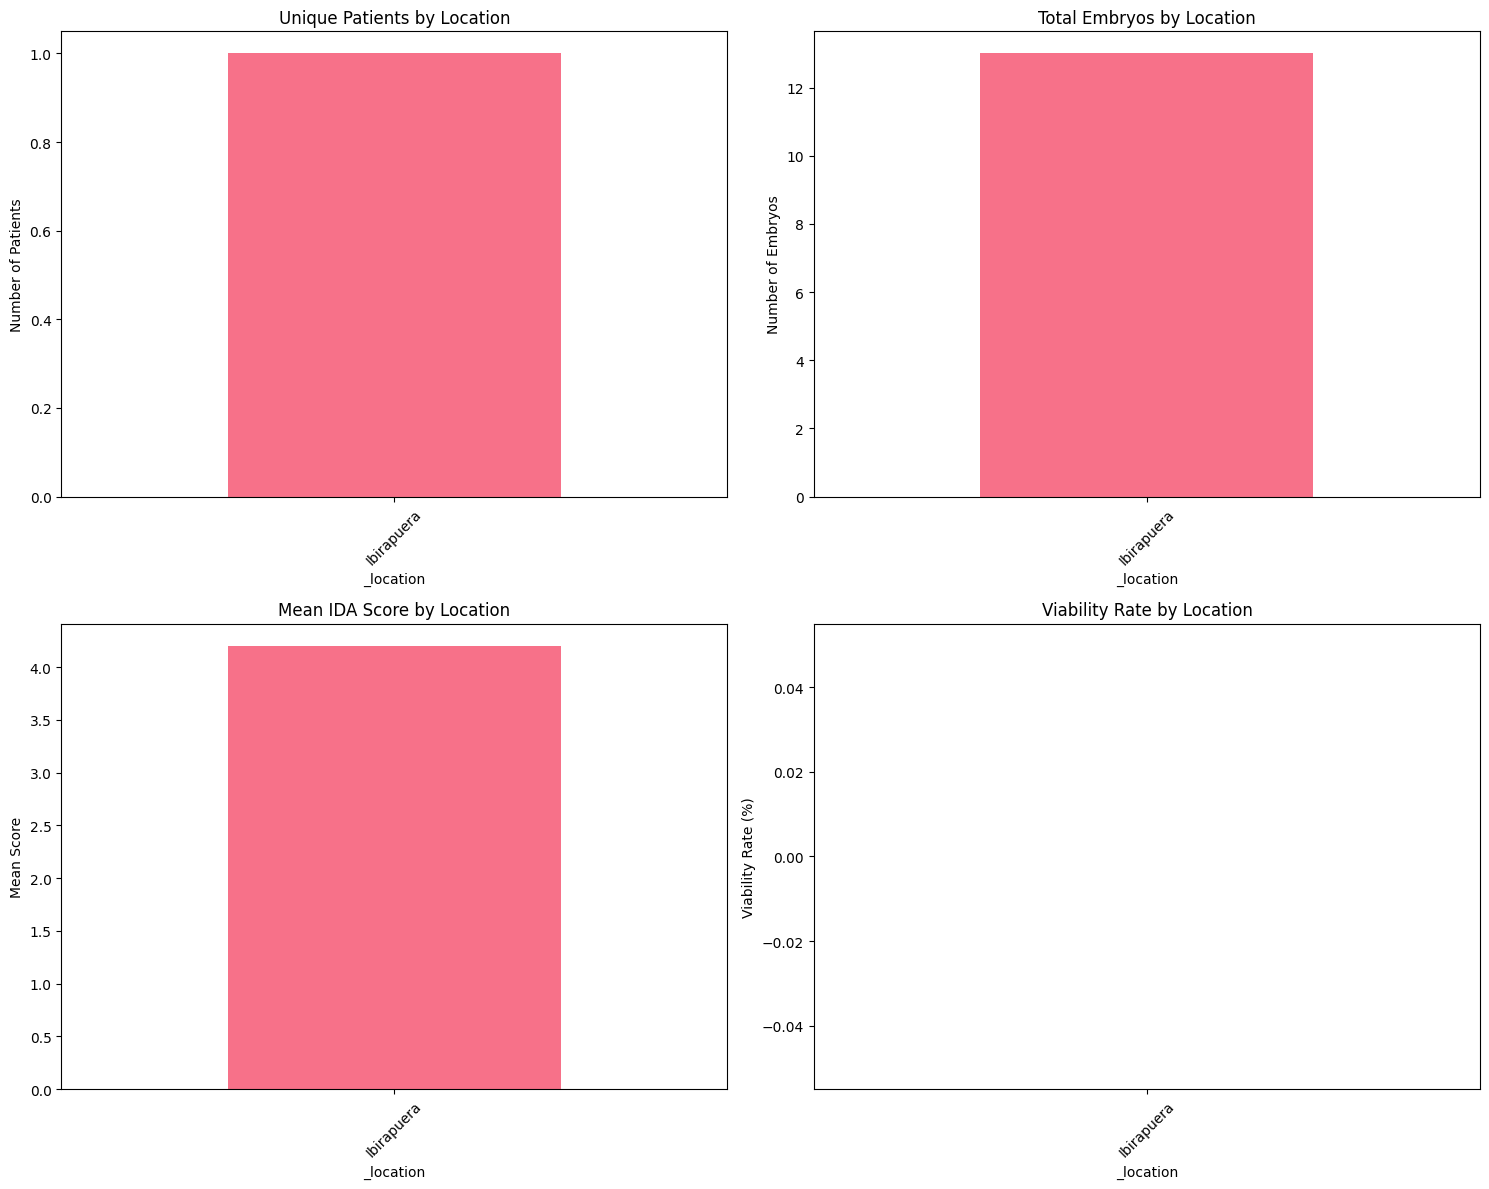

In [18]:
# Summary statistics by location using proper column names
# We'll use: 
#   - 'PatientIDx' for unique patients
#   - 'TreatmentName' for unique treatments
#   - 'EmbryoID' for total embryos
#   - 'KIDScore' for mean/std/count (if numeric)
#   - 'IDAScore' for viable embryos (if 'Viable' is a value)
# If 'KIDScore' is not numeric, skip mean/std.

# Ensure KIDScore is numeric if possible
if comprehensive_df['KIDScore'].dtype == object:
    try:
        comprehensive_df['KIDScore'] = pd.to_numeric(comprehensive_df['KIDScore'], errors='coerce')
    except Exception:
        pass

location_summary = comprehensive_df.groupby('_location').agg(
    Unique_Patients=('PatientIDx', 'nunique'),
    Unique_Treatments=('TreatmentName', 'nunique'),
    Total_Embryos=('EmbryoID', 'count'),
    Mean_Score=('KIDScore', 'mean'),
    Std_Score=('KIDScore', 'std'),
    Scored_Embryos=('KIDScore', 'count'),
    Viable_Embryos=('IDAScore', lambda x: (x == 'Viable').sum())
).round(3)

location_summary['Viability_Rate'] = (location_summary['Viable_Embryos'] / location_summary['Total_Embryos'] * 100).round(1)
location_summary = comprehensive_df.groupby('_location').agg({
    'PatientIDx': 'nunique',
    'TreatmentName': 'nunique',
    'EmbryoID': 'count',
    'KIDScore': ['mean', 'std', 'count'],
    'IDAScore': lambda x: (x == 'Viable').sum()
}).round(3)

location_summary.columns = ['Unique_Patients', 'Unique_Treatments', 'Total_Embryos', 
                           'Mean_Score', 'Std_Score', 'Scored_Embryos', 'Viable_Embryos']
location_summary['Viability_Rate'] = (location_summary['Viable_Embryos'] / location_summary['Total_Embryos'] * 100).round(1)

print("Summary by Location:")
print(location_summary)

# Plot summary
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Patients by location
location_summary['Unique_Patients'].plot(kind='bar', ax=ax1)
ax1.set_title('Unique Patients by Location')
ax1.set_ylabel('Number of Patients')
ax1.tick_params(axis='x', rotation=45)

# Embryos by location
location_summary['Total_Embryos'].plot(kind='bar', ax=ax2)
ax2.set_title('Total Embryos by Location')
ax2.set_ylabel('Number of Embryos')
ax2.tick_params(axis='x', rotation=45)

# Mean scores by location
location_summary['Mean_Score'].plot(kind='bar', ax=ax3)
ax3.set_title('Mean IDA Score by Location')
ax3.set_ylabel('Mean Score')
ax3.tick_params(axis='x', rotation=45)

# Viability rate by location
location_summary['Viability_Rate'].plot(kind='bar', ax=ax4)
ax4.set_title('Viability Rate by Location')
ax4.set_ylabel('Viability Rate (%)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Time Series Analysis

Time series data:
  extraction_date       _location  daily_embryos
0      2025-07-15        Brasilia          16532
1      2025-07-15      Ibirapuera          56335
2      2025-07-15    Vila Mariana          29753
3      2025-07-16  Belo Horizonte          22454
4      2025-07-16      Ibirapuera             24


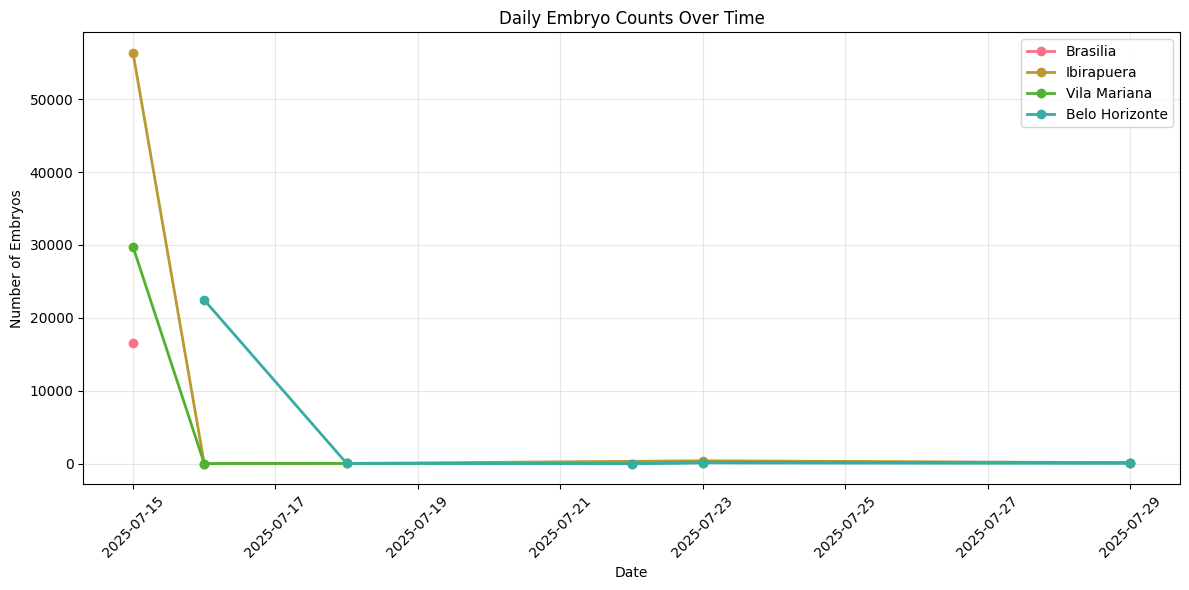

In [19]:
conn = duckdb.connect(db_path)

# Analyze data over time
time_series_query =f"""
SELECT 
    DATE(_extraction_timestamp) as extraction_date,
    _location,
    COUNT(*) as daily_embryos
FROM {schema}.embryo_data
GROUP BY DATE(_extraction_timestamp), _location
ORDER BY extraction_date, _location
"""

time_series_df = conn.execute(time_series_query).df()
conn.close()


time_series_df['extraction_date'] = pd.to_datetime(time_series_df['extraction_date'])

print("Time series data:")
print(time_series_df.head())

# Plot time series
plt.figure(figsize=(12, 6))
for location in time_series_df['_location'].unique():
    location_data = time_series_df[time_series_df['_location'] == location]
    plt.plot(location_data['extraction_date'], location_data['daily_embryos'], 
             marker='o', label=location, linewidth=2)

plt.title('Daily Embryo Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Embryos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Custom Queries

In [20]:
# conn = duckdb.connect(db_path)

# # Example: Find high-quality embryos
# high_quality_query = f"""
# SELECT 
#     e.EmbryoID,
#     e.PatientIDx,
#     e.TreatmentName,
#     e.EmbryoFate,
#     e._location,
#     e.KIDScore,
#     e.IDAScore
# FROM {schema}.embryo_data e
# JOIN {schema}.idascore s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
# WHERE e.KIDScore >= 0.8 AND e.IDAScore >= 5
#   --AND e._extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM data_embryo_data)
# ORDER BY s.Score DESC
# LIMIT 20
# """

# high_quality_df = conn.execute(high_quality_query).df()
# conn.close()

# print("Top 20 High-Quality Embryos (Score >= 0.8, Viable):")
# print(high_quality_df)

# # Plot time series
# plt.figure(figsize=(12, 6))
# for location in time_series_df['_location'].unique():
#     location_data = time_series_df[time_series_df['_location'] == location]
#     plt.plot(location_data['extraction_date'], location_data['daily_embryos'], 
#              marker='o', label=location, linewidth=2)

In [21]:
# # Example: Patient with most embryos
# patient_embryo_count_query = """
# SELECT 
#     e.PatientIDx,
#     e._location,
#     COUNT(*) as embryo_count,
#     AVG(s.Score) as avg_score,
#     SUM(CASE WHEN s.Viability = 'Viable' THEN 1 ELSE 0 END) as viable_count
# FROM embryoscope.data_embryo_data e
# LEFT JOIN embryoscope.data_idascore s ON e.EmbryoID = s.EmbryoID AND e._location = s._location
# --WHERE e._extraction_timestamp = (SELECT MAX(_extraction_timestamp) FROM data_embryo_data)
# GROUP BY e.PatientIDx, e._location
# ORDER BY embryo_count DESC
# LIMIT 10
# """

# patient_embryo_count_df = conn.execute(patient_embryo_count_query).df()
# print("Patients with Most Embryos:")
# print(patient_embryo_count_df)

## 10. Export Data

In [22]:
# # Export data to CSV files
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# # Export comprehensive data
# comprehensive_df.to_csv(f"embryoscope_comprehensive_{timestamp}.csv", index=False)
# print(f"Exported comprehensive data to: embryoscope_comprehensive_{timestamp}.csv")

# # Export high-quality embryos
# high_quality_df.to_csv(f"high_quality_embryos_{timestamp}.csv", index=False)
# print(f"Exported high-quality embryos to: high_quality_embryos_{timestamp}.csv")

# # Export summary by location
# location_summary.to_csv(f"location_summary_{timestamp}.csv")
# print(f"Exported location summary to: location_summary_{timestamp}.csv")

In [ ]:
# Close the database connection
conn.close()
print("Database connection closed.")

Database connection closed.


: 